In [ ]:

!pip install --quiet cirq==1.6.1
!pip install --quiet qsimcirq==0.22.0
!pip install --quiet qiskit==2.2.3


In [6]:
import cirq
import qsimcirq
import cirq_google
from cirq.contrib.svg import SVGCircuit
from qiskit.visualization import plot_histogram

# Overview

This notebook utilizes the Cirq framework to emulate and inspect the physical properties of Google's "Willow" quantum processor (willow_pink). By instantiating a SimulatedLocalEngine populated with real-world calibration data, we extract key metrics such as T1 relaxation times, gate error probabilities, and qubit topology.


# 1°: Basic Processor Configuration

Here, we initialize a SimulatedLocalEngine to mimic the behavior of the Google Quantum Computing Service locally. We specifically target the willow_pink processor ID to retrieve its median calibration data (GoogleNoiseProperties). This dataset provides a snapshot of the device's physical constraints, including readout errors and gate fidelities, allowing for realistic noise simulation without accessing the live QPU.

In [ ]:
virtual_processors = cirq_google.engine.list_virtual_processors()
print(virtual_processors)

['rainbow', 'weber', 'willow_pink']


In [ ]:
processor_id = "willow_pink"
noise_props = cirq_google.engine.load_device_noise_properties(processor_id)
noise_model = cirq_google.NoiseModelFromGoogleNoiseProperties(noise_props)
qsim = qsimcirq.QSimSimulator(noise=noise_model)

In [ ]:
device = cirq_google.engine.create_device_from_processor_id(processor_id)
cal = cirq_google.engine.load_median_device_calibration(processor_id)
sim_processor = cirq_google.engine.SimulatedLocalProcessor(
    processor_id=processor_id,
    sampler=qsim,
    device=device,
    calibrations={cal.timestamp // 1000: cal}
)
sim_engine = cirq_google.engine.SimulatedLocalEngine([sim_processor])

In [ ]:
print(sim_engine.get_processor(processor_id).get_device())

                                                        (0, 6)────(0, 7)────(0, 8)
                                                        │         │         │
                                                        │         │         │
                                              (1, 5)────(1, 6)────(1, 7)────(1, 8)
                                              │         │         │         │
                                              │         │         │         │
                                    (2, 4)────(2, 5)────(2, 6)────(2, 7)────(2, 8)────(2, 9)────(2, 10)
                                    │         │         │         │         │         │         │
                                    │         │         │         │         │         │         │
                           (3, 3)───(3, 4)────(3, 5)────(3, 6)────(3, 7)────(3, 8)────(3, 9)────(3, 10)
                           │        │         │         │         │         │         │         │
                    

# 2°: Native Gateset

In this section, we inspect the processor's supported instruction set architecture (ISA) by querying `device.metadata.gateset`. Understanding the native gates is critical for efficient circuit transpilation.

In [ ]:
gateset = device.metadata.gateset
print(gateset)

Gateset: 
FSimGateFamily: allow_symbol=False; atol=1e-06
`cirq_google.FSimGateFamily` which accepts any instance of gate types in
gate_types_to_check: [cirq.ops.fsim_gate.FSimGate,cirq.ops.fsim_gate.PhasedFSimGate,cirq.ops.swap_gates.ISwapPowGate,cirq.ops.phased_iswap_gate.PhasedISwapPowGate,cirq.ops.common_gates.CZPowGate,cirq.ops.identity.IdentityGate]
which matches (across types), via instance check / value equality, a gate in
gates_to_accept: [CZ]

Instance GateFamily: CZ
Accepts `cirq.Gate` instances `g` s.t. `g == CZ`

Type GateFamily: cirq.ops.measurement_gate.MeasurementGate
Accepts `cirq.Gate` instances `g` s.t. `isinstance(g, cirq.ops.measurement_gate.MeasurementGate)`

Instance GateFamily: I
Accepts `cirq.Gate` instances `g` s.t. `g == I`

Type GateFamily: cirq.ops.phased_x_z_gate.PhasedXZGate
Accepts `cirq.Gate` instances `g` s.t. `isinstance(g, cirq.ops.phased_x_z_gate.PhasedXZGate)`

Type GateFamily: cirq.ops.common_gates.XPowGate
Accepts `cirq.Gate` instances `g` s.t. `i

# 3°: Accessing Processor Data

In this step, we initialize the processor instance and retrieve its latest calibration data. Specifically, we are interested in the $T_1$ (single-qubit idle time) metrics.

This loop iterates through the available qubits (mapped as cirq.GridQubit) and extracts their relaxation times in microseconds. These values are essential for understanding the stability and coherence duration of the Willow processor before errors occur.

In [ ]:
processor = sim_engine.get_processor(processor_id)

In [ ]:
qpu_data = processor.list_calibrations()[0]

In [ ]:
times = []
for qubit, time in qpu_data['single_qubit_idle_t1_micros'].items():
  print(f"Qubit: {qubit} | {time[0]}")
  times.append(time[0])

Qubit: (cirq.GridQubit(0, 6),) | 71.88662925116905
Qubit: (cirq.GridQubit(0, 7),) | 71.88332576142263
Qubit: (cirq.GridQubit(0, 8),) | 38.012331507235764
Qubit: (cirq.GridQubit(1, 5),) | 84.53014245902317
Qubit: (cirq.GridQubit(1, 6),) | 84.86048108190231
Qubit: (cirq.GridQubit(1, 7),) | 67.16480414487289
Qubit: (cirq.GridQubit(1, 8),) | 74.61048170403096
Qubit: (cirq.GridQubit(2, 4),) | 68.76977641643778
Qubit: (cirq.GridQubit(2, 5),) | 82.41664773572367
Qubit: (cirq.GridQubit(2, 6),) | 75.24448603265387
Qubit: (cirq.GridQubit(2, 7),) | 72.74841450214323
Qubit: (cirq.GridQubit(2, 8),) | 79.08571917500265
Qubit: (cirq.GridQubit(2, 9),) | 85.47569140885952
Qubit: (cirq.GridQubit(2, 10),) | 75.82422408296706
Qubit: (cirq.GridQubit(3, 3),) | 81.14078896877776
Qubit: (cirq.GridQubit(3, 4),) | 55.485504273474085
Qubit: (cirq.GridQubit(3, 5),) | 49.694914518420184
Qubit: (cirq.GridQubit(3, 6),) | 78.45342205468239
Qubit: (cirq.GridQubit(3, 7),) | 62.95167553175413
Qubit: (cirq.GridQubit(3, 8

# 4°: Building a Simple Circuit

In this section, we create a simple quantum circuit to generate a Bell State (an entangled pair of qubits). We select two specific qubits on the grid: (4, 4) and (4, 5). The workflow consists of three stages:
1.   Circuit Design: We define a standard Bell State using a Hadamard gate (H) followed by a CNOT.

2.   Transpilation (Compilation): Real quantum hardware often supports a limited set of "native" gates. We use cirq.optimize_for_target_gateset to translate our abstract circuit into operations the Willow processor physically executes (visible in the second diagram as PhXZ gates).

3.   Execution & Analysis: We run the compiled circuit 3,000 times. The final histogram confirms strong entanglement, with the vast majority of results collapsing into the $|00\rangle$ and $|11\rangle$ states.


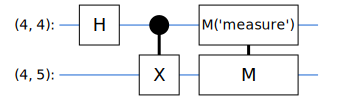

In [ ]:
q0, q1 = cirq.GridQubit(4, 4), cirq.GridQubit(4, 5)

circuit = cirq.Circuit(
    cirq.H(q0),
    cirq.CNOT(q0, q1),
    cirq.measure([q0, q1], key="measure")
)
SVGCircuit(circuit)

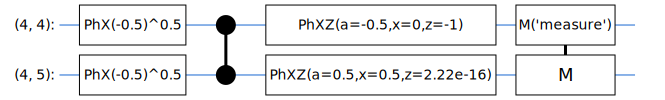

In [ ]:
# extrai um CompilationTargetGateset válido
target_gatesets = device.metadata.compilation_target_gatesets

# escolhe um deles
target = target_gatesets[0]

# transpila o circuito
circuit_native = cirq.optimize_for_target_gateset(
    circuit,
    gateset=target
)

SVGCircuit(circuit_native)

In [ ]:
results = sim_engine.get_sampler(processor_id).run(circuit_native, repetitions=3000)
counter = results.histogram(key="measure")
print(counter)

Counter({0: 1488, 3: 1457, 1: 29, 2: 26})


In [ ]:
n_qubits = 2
new_counter = {}
for val, count in counter.items():
    # converte para binário com padding
    bstr = format(val, f"0{n_qubits}b")
    new_counter[bstr] = count

In [ ]:
new_counter

{'00': 1488, '11': 1457, '10': 26, '01': 29}

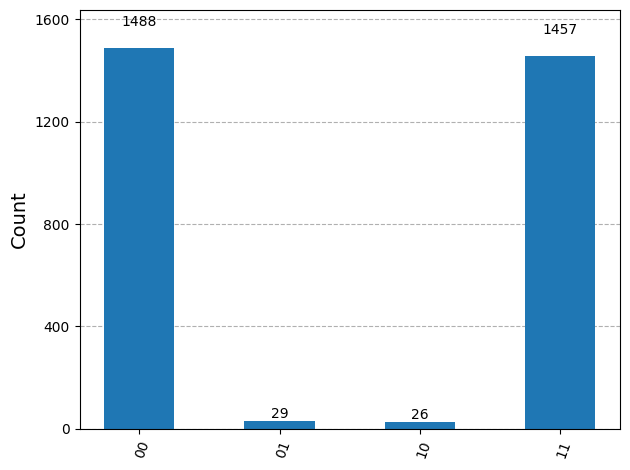

In [ ]:
plot_histogram(new_counter)